# Fluvial Joint Probability

__Description__: Tool to calculate the joint probability of discharge of two or more flow boundary conditions using the procedure outlined in [Estimating Joint Probabilities of Design Coincident Flows at Stream Confluences](http://onlinepubs.trb.org/onlinepubs/nchrp/nchrp_w199.pdf).

__Input__: 
- The *Fluvial_Parameters.xlsx* which contains information on the external flow boundary conditions, including their names and drainage areas. 
- The *Sampler_Operation_.xlsx* for each flow boundary condition, which contains the mean flow frequency curve. This Excel Workbook is created by the `PM_Sampler_Ops` Jupyter Notebook.
- The normalized mean hydrographs *.json* for each boundary condition whose joint probability is to be calculated. This *.json* is created by the `NormalizedMeanHydrograph` Jupyter Notebook.
- `DataRepository` folder which contains the following:
    - The *Joint_Prob_Lookup.csv*, which distills the return period combinations for the Representative Approach from Table H.3. through H.7. in [Estimating Joint Probabilities of Design Coincident Flows at Stream Confluences](http://onlinepubs.trb.org/onlinepubs/nchrp/nchrp_w199.pdf). Note that the original values found in Tables H.3. to H.7. were transformed so that the secondary (main stem or tributary) return period can be found by dividing the primary return period by the value in the table.
    - The *Fluvial_Events_List.csv*, which contains the event ID, weight, and return period for a predetermined list of fluvial events.

__Output__: The joint probability hydrographs for each flow boundary condition and event as a *.json*, along with the event weights as a *.json*.

*Acknowledgement*: This notebook was adapated from "Join_Pr_Tool-No Envelop Values.xlsx," which was developed by [Kaveh Zomorodi](kzomorodi@Dewberry.com).

---

## A. Load Libraries, Parameters, and Data:
### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from nb_libraries import*
from fluvial_hydro import*

### Parameters:
#### Site specific:

In [2]:
## Filenames and paths:
Project_Area = 'DC'    # Project area name
Fluvial_Model = 'F02'  # Fluvial model name
Domain = 'D01'         # Name of the model domain

fluvial_params = '{0}_{1}_Fluvial_Parameters.xlsx'.format(Project_Area, Fluvial_Model)

root_dir = pl.Path(os.getcwd())
inputs_dir = root_dir/'Inputs/{0}_{1}'.format(Project_Area, Fluvial_Model)
outputs_dir = root_dir/'Outputs'
forcing_dir = outputs_dir/'{0}_{1}_Forcing'.format(Project_Area, Fluvial_Model)
datarepository_dir = root_dir/'DataRepository'
fluvial_params_dir = inputs_dir/fluvial_params

## Options:
verbose = True

#### Project specific (global):

In [3]:
Lookup_Table = 'Joint_Prob_Lookup.csv'
Events_List = 'Fluvial_Events_List.csv'

## Options:
min_RI = 1.01             # Minimum return period since AEP cannot be greater than 1
perc_mean = 0.90          # Percent of the annual mean discharge used for flow boundaries whose joint probability is not calculated
round_to_int = False      # Round return periods to integers
jp_main_only = False      # Calculate the joint probability using only the first combination in Tables H.3. to H.7. 
fluvial_BC_units = 'cfs'  # The fluvial boundary condition units

### Data:
#### Joint probability lookup table:

In [4]:
lookup = pd.read_csv(datarepository_dir/Lookup_Table, index_col = 'Category')
lookup.head(2)

,RI<10,RI=10,10<RI<25,RI=25,25<RI<50,RI=50,50<RI<100,RI=100,100<RI<500,RI=500,RI>500
Category,,,,,,,,,,,
SS,3,3.333333,3.75,4.166667,4.3,4.545455,4.7,5.000000,5,5.102041,5.1
SL,5,5.000000,6.50,8.333333,9.0,10.000000,10.5,11.111111,12,12.820513,13.0


#### Fluvial events list:

In [5]:
events = pd.read_csv(datarepository_dir/Events_List, index_col = 'Events')
events.head(2)

,Weight,RI
Events,,
E0001,0.035594,2.073100
E0002,0.032774,2.230391


#### External flow boundary table:

In [6]:
fp = pd.read_excel(fluvial_params_dir, sheet_name = 'External_Flow', index_col = 'Boundary Condition')
fp.head(2)

,Gage ID,Gage Name,Drainage Area (miles^2),Annual Mean (cfs),Joint Probability (YES or NO),Comments
Boundary Condition,,,,,,
F01,1646500,"POTOMAC RIVER NEAR WASH, DC LITTLE FALLS PUMP STA",11560.0,11500.0,NO,NaN
F02,1651000,"NORTHWEST BR ANACOSTIA RIVER NR HYATTSVILLE, MD",49.4,51.4,YES,NaN


##### Identify boundaries for calculating joint probability:

In [7]:
BCNs = identify_jp_bcns(fp, verbose)

Calculate joint probability for:  ['F02', 'F03']


##### Identify remaining boundaries:

In [8]:
re_BCNs = identify_remaining_bcns(fp, BCNs, verbose)

Remaining flow boundaries: ['F01']


#### Fluvial model parameters:

In [9]:
fm = pd.read_excel(fluvial_params_dir, sheet_name = 'Fluvial_Model', index_col = 'Fluvial Model')
fm.head(2)

,Run Duration (Days),Timestep (Minutes),Time Index Ordinate
Fluvial Model,,,
F02,2,5,Hours


##### Extract the run duration and timestep:

In [10]:
run_dur, tstep, idx_ord = extract_fmodel_params(fm, Fluvial_Model, 'Run Duration (Days)', 'Timestep (Minutes)', 'Time Index Ordinate', verbose)

Run duration: 2 days 
Timestep: 5 minutes 
Time index ordinate: Hours
Note: the run duration and timestep are assumed to have units of days and minutes, respectively


#### Mean flow frequncy curves:

In [11]:
ffc = ffc_dic(BCNs, fp, inputs_dir, verbose)

Flow frequency curve for F02:


,Q_Mean_cfs,Q_Median_cfs
AEP,,
0.9,1677.026488,1674.7
0.5,3374.838485,3338.6


Flow frequency curve for F03:


,Q_Mean_cfs,Q_Median_cfs
AEP,,
0.9,1849.018117,1867.2
0.5,3873.021885,3873.6


#### Normalized mean hydrographs:

In [12]:
nhydros = load_normhydros(inputs_dir, BCNs, Project_Area, Fluvial_Model)

Loaded normalized mean hydrograph for F02
Loaded normalized mean hydrograph for F03


---
## B. Calculate Joint Probability Return Periods:

In [13]:
jptables = joint_prob_tables(BCNs, fp, events, lookup, min_RI, round_to_int=round_to_int, jp_main_only=jp_main_only, verbose = verbose)

Joint probability pairs: [('F02', 'F03')]
Total drainage area: 122.2 square miles; drainage area ratio: 1.47

Watershed Category: SS

Joint probability table for F03_F02:


,Weight,RI_F03,RI_F02
Events,,,
E0001,0.017797,2.07,1.01
E0002,0.016387,2.23,1.01


None


---
## C. Determine Discharge for each Return Period:

In [14]:
jptable_q = joint_prob_q(copy.deepcopy(jptables), ffc, verbose) 

,Weight,RI_F02,RI_F03,Q_F02,Q_F03
Events,,,,,
E0001,0.017797,1.01,2.07,946,3967
E0002,0.017797,2.07,1.01,3472,1009


---
## D. Add Remaining External Flow Boundaries:

In [15]:
jptable_q = add_remaining_bcns(re_BCNs, fp, jptable_q, perc_mean, verbose)

,Weight,RI_F02,RI_F03,Q_F02,Q_F03,Q_F01
Events,,,,,,
E0001,0.017797,1.01,2.07,946,3967,10350
E0002,0.017797,2.07,1.01,3472,1009,10350


---
## E. Convert Peak Discharge to Hydrographs:

### Build a dictionary to store the hydrographs:

In [16]:
ff_dic = build_fluvial_dict(run_dur, tstep, idx_ord, fluvial_BC_units, verbose)

Dictionary structure: 
 ['Fluvial']
  ['time_idx_ordinate', 'run_duration_days', 'time_idx', 'fluvial_BC_units', 'BCName']


#### Extract the time index:

In [17]:
idx = ff_dic['Fluvial']['time_idx']

### Calculate the hydrographs for each joint probability boundary condition:

In [18]:
for bcn in BCNs:
    ff_dic['Fluvial']['BCName'][bcn] = calc_norm_hydros(jptable_q, nhydros[bcn], bcn, idx, verbose)

Normalized mean hydrographs calculated for F02
Original peak min: 946, max: 87588
Hydrograph peak min: 945, max: 87515

Normalized mean hydrographs calculated for F03
Original peak min: 1009, max: 32457
Hydrograph peak min: 1008, max: 32451



### Add any remaining boundary conditions to the dictionary as uniform hydrographs:

In [19]:
for bcn in re_BCNs:
    ff_dic['Fluvial']['BCName'][bcn] = calc_uniform_hydros(jptable_q, bcn, idx, verbose)

Uniform hydrographs calculated for F01


### Plot both the normalized mean and uniform hydrographs:

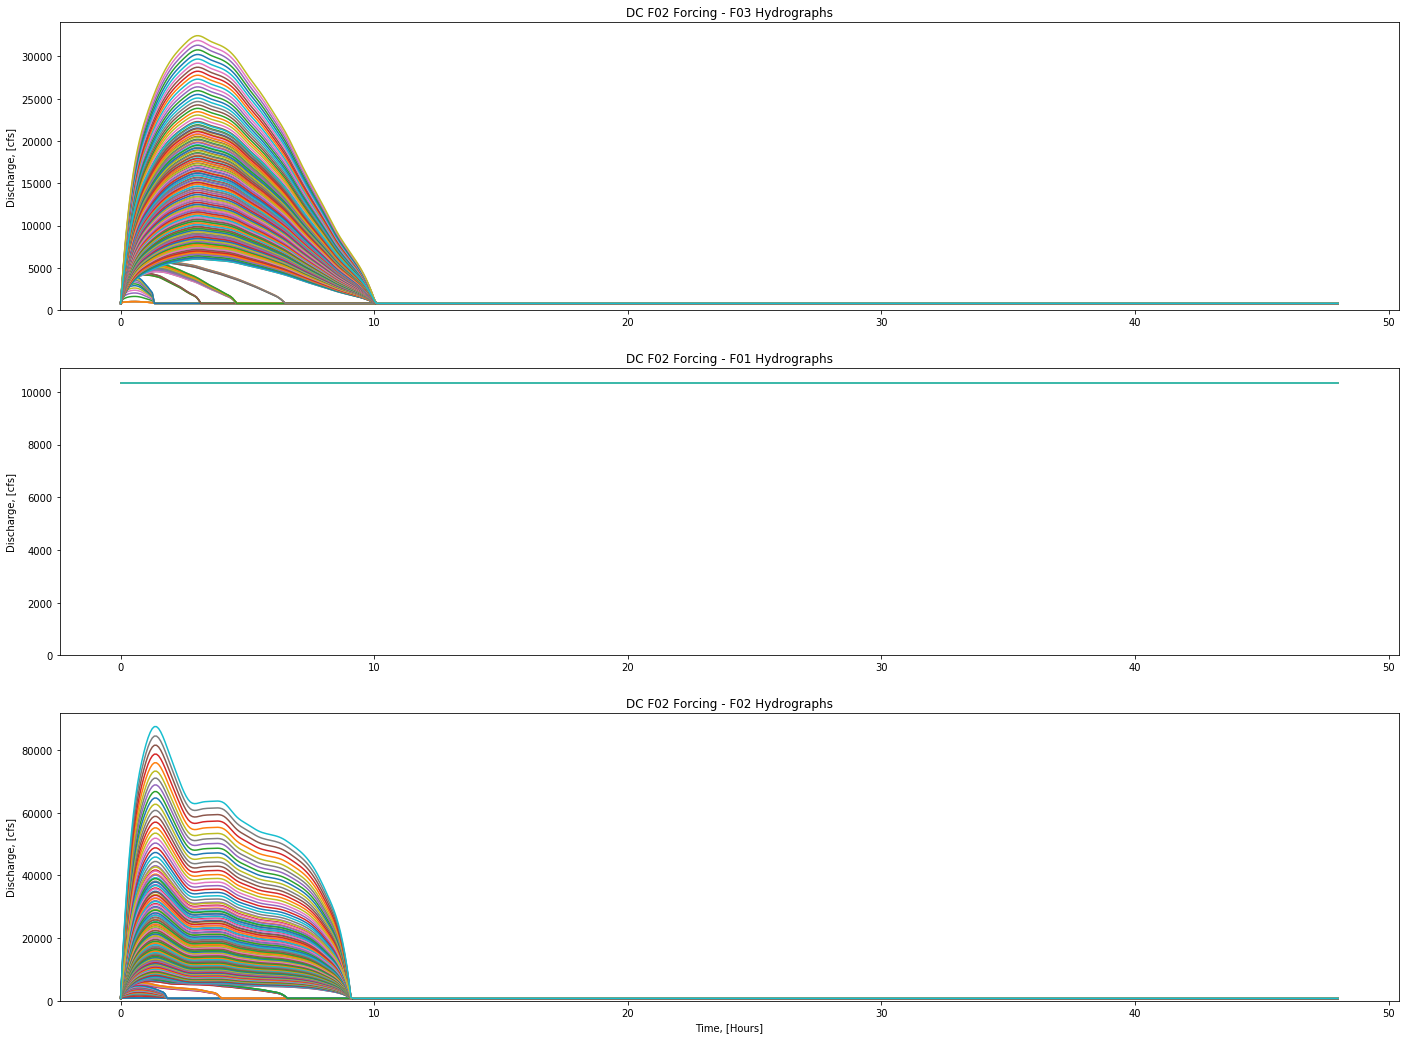

In [20]:
plot_normalized_uniform_hydro(ff_dic, Project_Area, Fluvial_Model)

---
## F. Save the Results:
### Fluvial Forcing:

In [21]:
with open(forcing_dir/'{0}_{1}_{2}.json'.format(Project_Area, Fluvial_Model, Domain), 'w') as f:
    json.dump(ff_dic, f)

### Fluvial Weights:

In [22]:
weights_dic  = build_fluvial_weights_dic(Domain, jptable_q)

with open(outputs_dir/'{0}_{1}_{2}_Weights.json'.format(Project_Area, Fluvial_Model, Domain), 'w') as f:
    json.dump(ff_dic, f)

---
## End